# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Handling Missing Values](#handling-missing-values)
3. [Feature Distributions](#feature-distributions)
4. [Possible Biases](#possible-biases)
5. [Correlations](#correlations)

In [1]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import requests
import time
import math

## Dataset Overview

The dataset consists of 1,000 seabed tiles, evenly distributed into two classes: 500 tiles containing seamounts and 500 without. The tiles were downloaded via the [gmrt.org](https://www.gmrt.org/) API, using an additional database of already identified seamounts.

To create the seamount tiles, the center of a known seamount was used as a reference, downloaded, and manually sorted to select those that clearly contained well-defined, round seamounts.

A different approach was used for the non-seamount tiles. First, the global coastline was used to identify oceanic coordinates. Random positions were then selected and checked to ensure they did not overlap with any known seamount locations before being downloaded via the API. This selection was also manually reviewed to ensure that all 500 tiles definitively contained no seamounts.



### Sample image :

![alt text](tile_30.9_31.7_-55.0_-54.0.png)

### Sample image with high resolution highlighted "masked" that show the ships path:

![alt text](<tile_30.9_31.7_-55.0_-54.0 (1).png>)

## Handling Missing Values

### There are no missing values as such, but:

- Some of the images contains high and low resolution areas
- In the low-res parts of the images the information density is probably too low to work with it and get results (too blurry), so the entire low-res area could be regarded as missing information.


![Tile with different resolution](<../3_Model/main_input_data/data_241208/without_seamounts_manual1/374918.0.png>)

- Some of the tiles contains more than one seamount


![Tile with more than one seamount](<../3_Model/main_input_data/data_241208/with_seamount_manual1/551299.0.png>)

## Feature Distributions


Statistics for folder ../3_Model/main_input_data/temp_processed_data_241208/with_seamount_manual1/ saved to with_seamount_image_stats.csv


[ WARN:0@869.395] global loadsave.cpp:268 findDecoder imread_('577669.0.png'): can't open/read file: check file path/integrity


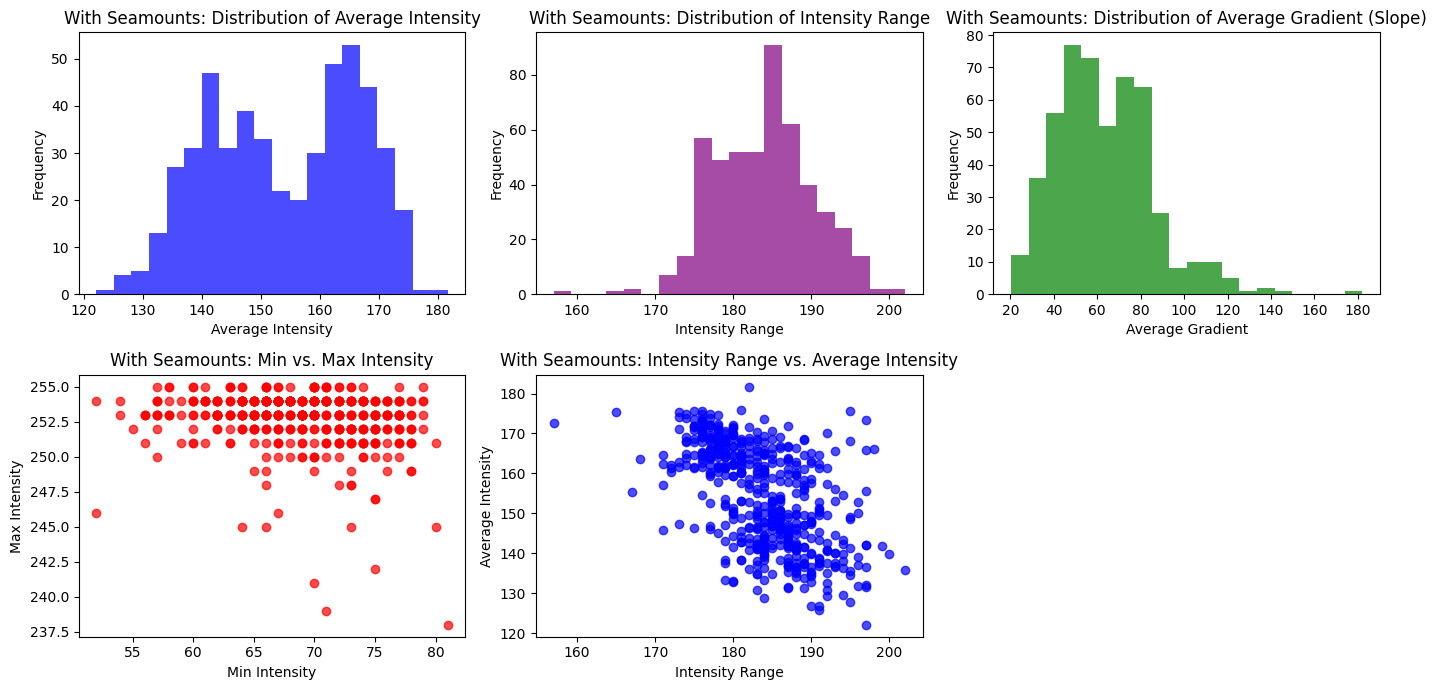

Statistics for folder ../3_Model/main_input_data/temp_processed_data_241208/without_seamounts_manual1/ saved to without_seamounts_image_stats.csv


[ WARN:0@870.242] global loadsave.cpp:268 findDecoder imread_('tile_31.2_-20.0.png'): can't open/read file: check file path/integrity


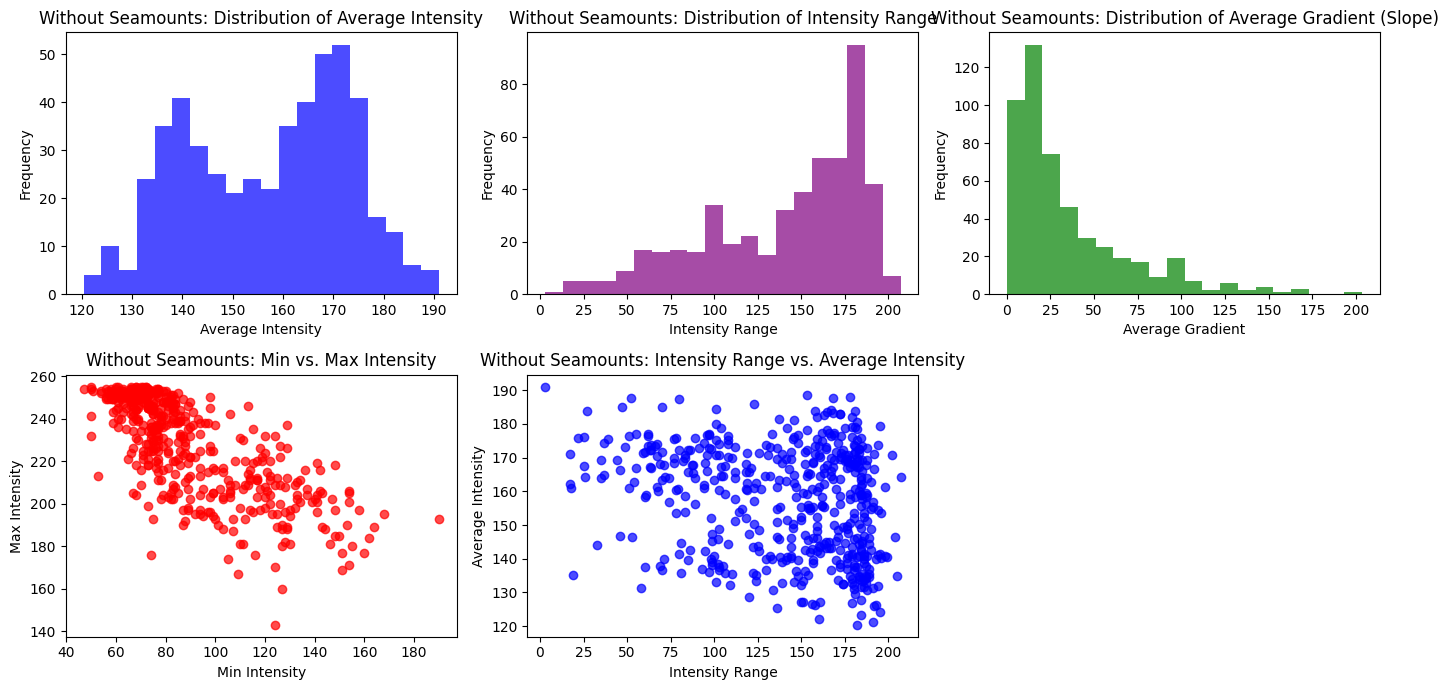

In [7]:
# Parameters
folders = [
    {"image_folder": "../3_Model/main_input_data/temp_processed_data_241208/with_seamount_manual1/",
     "output_csv": "with_seamount_image_stats.csv",
     "title_prefix": "With Seamounts"},
    {"image_folder": "../3_Model/main_input_data/temp_processed_data_241208/without_seamounts_manual1/",
     "output_csv": "without_seamounts_image_stats.csv",
     "title_prefix": "Without Seamounts"}
]

# Function to compute the gradient magnitude of the image
def compute_gradient_magnitude(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grad_x = cv2.Sobel(grayscale, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(grayscale, cv2.CV_64F, 0, 1, ksize=3)
    grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    return grad_magnitude

# Function for visualizations
def create_visualizations(df, title_prefix):
    plt.figure(figsize=(14, 7))

    # Average intensity distribution
    plt.subplot(2, 3, 1)
    plt.hist(df["avg_intensity"], bins=20, color="blue", alpha=0.7)
    plt.title(f"{title_prefix}: Distribution of Average Intensity")
    plt.xlabel("Average Intensity")
    plt.ylabel("Frequency")

    # Intensity range distribution (min/max intensity)
    plt.subplot(2, 3, 2)
    plt.hist(df["intensity_range"], bins=20, color="purple", alpha=0.7)
    plt.title(f"{title_prefix}: Distribution of Intensity Range")
    plt.xlabel("Intensity Range")
    plt.ylabel("Frequency")

    # Average gradient distribution (to represent terrain slope)
    plt.subplot(2, 3, 3)
    plt.hist(df["avg_gradient"], bins=20, color="green", alpha=0.7)
    plt.title(f"{title_prefix}: Distribution of Average Gradient (Slope)")
    plt.xlabel("Average Gradient")
    plt.ylabel("Frequency")

    # Min intensity vs. max intensity
    plt.subplot(2, 3, 4)
    plt.scatter(df["min_intensity"], df["max_intensity"], alpha=0.7, color="red")
    plt.title(f"{title_prefix}: Min vs. Max Intensity")
    plt.xlabel("Min Intensity")
    plt.ylabel("Max Intensity")

    # Intensity range vs. average intensity
    plt.subplot(2, 3, 5)
    plt.scatter(df["intensity_range"], df["avg_intensity"], alpha=0.7, color="blue")
    plt.title(f"{title_prefix}: Intensity Range vs. Average Intensity")
    plt.xlabel("Intensity Range")
    plt.ylabel("Average Intensity")

    # Example image heatmap
    example_image_path = df.iloc[0]["file_name"]  # Get the first file name
    example_image = cv2.imread(example_image_path)
    if example_image is not None:
        plt.subplot(2, 3, 6)
        plt.imshow(example_image, cmap='terrain', interpolation='nearest')
        plt.title(f"{title_prefix}: Example Image (Heatmap)")
        plt.colorbar(label="Shading Intensity")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Process each folder
for folder in folders:
    image_folder = folder["image_folder"]
    output_csv = folder["output_csv"]
    title_prefix = folder["title_prefix"]
    
    # Load images
    image_paths = glob(os.path.join(image_folder, "*.png"))
    if not image_paths:
        print(f"No images found in the folder: {image_folder}")
        continue

    # Data storage
    data = []

    # Loop through each image
    for image_path in image_paths:
        try:
            # Reload and process image each time
            image = cv2.imread(image_path)
            if image is None:
                print(f"Image {image_path} is corrupt or unreadable.")
                continue

            height, width, channels = image.shape
            
            # Convert to grayscale for intensity analysis
            grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            # Average and standard deviation of intensity
            avg_intensity = np.mean(grayscale)
            std_intensity = np.std(grayscale)
            
            # Gradient magnitude (to detect terrain slope)
            grad_magnitude = compute_gradient_magnitude(image)
            avg_gradient = np.mean(grad_magnitude)  # Mean gradient value across the image
            
            # Elevation statistics (inferred from intensity)
            min_intensity = np.min(grayscale)
            max_intensity = np.max(grayscale)
            intensity_range = max_intensity - min_intensity

            # Store data
            data.append({
                "file_name": os.path.basename(image_path),
                "width": width,
                "height": height,
                "avg_intensity": avg_intensity,
                "std_intensity": std_intensity,
                "min_intensity": min_intensity,
                "max_intensity": max_intensity,
                "intensity_range": intensity_range,
                "avg_gradient": avg_gradient,
                "aspect_ratio": width / height,
            })

        except Exception as e:
            print(f"Error processing {image_path}: {e}")

    # Create a DataFrame for analysis
    df = pd.DataFrame(data)

    # Save to CSV
    df.to_csv(output_csv, index=False)
    print(f"Statistics for folder {image_folder} saved to {output_csv}")

        # Create visualizations for the folder
    create_visualizations(df, title_prefix)

## Possible Biases

- Both classes has the same count of images -> no impact of bias of one of the classes
- Images in class "Without Seamounts" might be too "flat" and with to low average gradient, what might lead the model to predict more on the gradient that to detect the shape of a seamount -> most of the floor without seamounts look like this so we decided to keep it, but include some more images with "un-seamount structure"
- Some of the images contain more than one seamount -> potential impact should be low

## Correlations

[Explore correlations between features and the target variable, as well as among features themselves.]
- height information is inferred from the shadows and light, so maybe correlation of stark contrast in images and "mountaineous areas"
